# Quantify neuron importance in nonlinear decoder

the general question is, how shoudl we quanitfy the importance of each feature dim.

some thoughts:
- Permutation: permuting each feature and measuring the drop in model performance to determine the importance of each feature. its like the inference dropout. if the feature is more important, the acc should drop more.
- Feature Sensitivity Analysis: By systematically varying one feature while keeping others fixed and observing the effect on model output, you can gauge the sensitivity of the model to each feature. eg, we when the feaure vary from 0-1, how much would the output vary. the large the output varys, the more important the feature.
- Partial Derivatives: Analyzing the partial derivatives of the output with respect to each input can provide insights into the impact of individual dimensions on the output. the idea is simlar to above. if the partial diff is larger, it means if we chagne the dim slightly, the output will change greatly.
- PCA: PCA can be used to identify the dimensions that capture the most variance in the data. Dimensions with higher variance are typically considered more important. 
but it ignores that some small variation that truly correlate to the output.
- Information Gain: Information theoretic measures such as entropy or mutual information can be used to quantify the amount of information provided by each dimension. not sure how to start.



## ground truth
we make a ground truth to test this.
x has 3 dim. dim1 is truely correlate to y with some noise, dim2 has larger noise and correlate to y less, dim3 is not in correlation to y at all.
y is 1 dim.
then we train a tiny torch network to predict y from x. 

In [159]:
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import clear_output

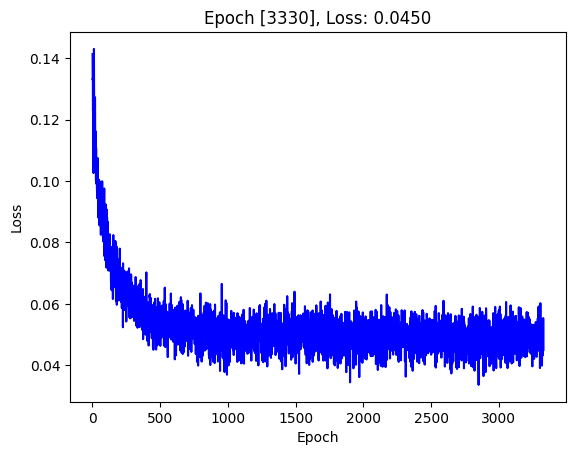

In [160]:
def normalize(vector):
    min_value = torch.min(vector)
    max_value = torch.max(vector)
    # Normalize the vector to the range [0, 1]
    normalized_vector = (vector - min_value) / (max_value - min_value)
    return normalized_vector

def generate_data():
    x = torch.rand((555, 3)) 
    # x[:, 0]=x[:, 1]+torch.rand_like(x[:, 1])*0.1
    x[:, 1]=torch.normal(x[:, 0],0.1)
    # x[:, 1]=x[:, 1]+torch.rand_like(x[:, 1])*0.1
    y=(torch.normal(x[:, 0],0.1) + torch.rand_like(x[:, 1])*0.1)
    y=normalize(y)
    return x, y


In [ ]:

class TinyNet(nn.Module):
    def __init__(self,p=0.5):
        super(TinyNet, self).__init__()
        self.fc1 = nn.Linear(3, 2)  # Fully connected layer 1
        self.fc2 = nn.Linear(2, 1)  # Fully connected layer 2 (output layer)
        self.dropout = nn.Dropout(p=p) 

    def forward(self, x):
        x = self.dropout(x)
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)
        x = (self.fc2(x))
        return x

model = TinyNet()
model.train()
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.SGD(model.parameters(), lr=0.007, weight_decay=0.001) 

losses = []
for epoch in range(3333):  # You can adjust the number of epochs
    x,y=generate_data()

    optimizer.zero_grad()
    outputs = model(x)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 111 == 0:
        # print(f"Epoch [{epoch+1}/1000], Loss: {loss.item():.4f}")
        clear_output(wait=True)
        plt.plot(range(1, epoch+2), losses, color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Epoch [{epoch+1}], Loss: {loss.item():.4f}")
        plt.show()


based on the plot, we can see the loss is miminized. 
note that this model is not very stable (idk why) the result is not stable across runs. 

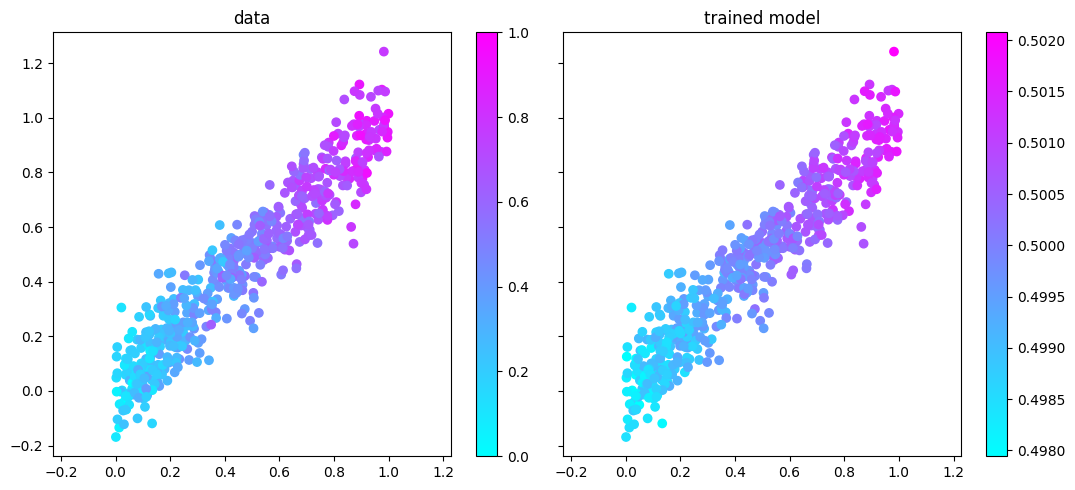

In [161]:
x,y=generate_data()

fig, axs = plt.subplots(1, 2, figsize=(11, 5),sharey=True,)
ax=axs[0]
vmin,vmax=torch.min(y),torch.max(y)
c=ax.scatter(x[:,0],x[:,1], c=y, cmap='cool', vmin=vmin, vmax=vmax)
plt.colorbar(c)
ax.axis('equal')
ax.set_title('data')

ax=axs[1]
model.eval()
vmin,vmax=torch.min(y),torch.max(y)
c=ax.scatter(x[:,0],x[:,1], c=(model(x)).detach().numpy(), cmap='cool')
plt.colorbar(c)
ax.axis('equal')
ax.set_title('trained model')
plt.tight_layout()



the results of training.   
left, we have the ground truth data.   
right, we have the model prediction.   
the data is made to correlate with dim 1 the best. correlate to dim 2 with same strangth but with more noise. does not correlate to dim 3 at all(did not plot here).

In [162]:
# Now you can use the trained model to predict y for new input data
new_x = torch.tensor([[0.9, 0.9, 0.0]])  # Example new input
predicted_y = model(new_x)
groundtruth=  13*new_x[:, 0] + 5*new_x[:, 1]
print(f"Predicted y for new input {new_x}: \n   {predicted_y.item():.4f}  ground truth y: {groundtruth}")

new_x = torch.tensor([[0.1, 0.1, 0.0]])  # Example new input
predicted_y = model(new_x)
groundtruth=  13*new_x[:, 0] +  5*new_x[:, 1]
print(f"Predicted y for new input {new_x}: \n   {predicted_y.item():.4f}  ground truth y: {groundtruth}")

Predicted y for new input tensor([[0.9000, 0.9000, 0.0000]]): 
   0.5017  ground truth y: tensor([16.2000])
Predicted y for new input tensor([[0.1000, 0.1000, 0.0000]]): 
   0.4992  ground truth y: tensor([1.8000])


## 1: feature sensitivity


### sum of weights

0.09562689
0.021761987


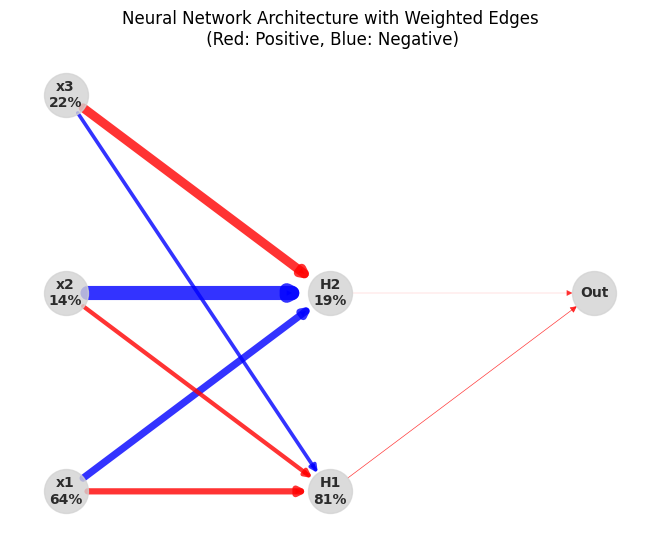

In [163]:


# Define the weight matrices
weights_input_hidden = (model.fc1.weight.clone().detach().numpy() )*5# Example weight matrix from input to hidden layer
weights_hidden_output = (model.fc2.weight.clone().detach().numpy())*5  # Example weight matrix from hidden to output layer

# Initialize a graph
G = nx.DiGraph()

# Add nodes for input layer
importance_input=np.sum(abs(weights_hidden_output@weights_input_hidden), axis=0)
importance_input=importance_input/sum(importance_input)*100
input_nodes = ['x1', 'x2', 'x3']
input_nodes=[a+'\n'+f'{b:.0f}%' for a, b in zip(input_nodes, importance_input)]
G.add_nodes_from(input_nodes, layer_type='input')

# Add nodes for hidden layer
importance_hid=np.sum(abs(weights_hidden_output), axis=0)
importance_hid=importance_hid/sum(importance_hid)*100
hidden_nodes = ['H1', 'H2', 'H3']
hidden_nodes=[a+'\n'+f'{b:.0f}%' for a, b in zip(hidden_nodes, importance_hid)]
G.add_nodes_from(hidden_nodes, layer_type='hidden')

# Add node for output layer
output_node = 'Out'
G.add_node(output_node, layer_type='output')


# Add edges from input layer to hidden layer
for j, input_node in enumerate(input_nodes):
    for i, hidden_node in enumerate(hidden_nodes):
        weight = weights_input_hidden[i, j] # row is to hidden.
        G.add_edge(input_node, hidden_node, weight=weight)

# Add edges from hidden layer to output layer
for j, hidden_node in enumerate(hidden_nodes):
    weight = weights_hidden_output[0, j]
    print(weight)
    G.add_edge(hidden_node, output_node, weight=weight)

# Manually set positions of nodes
pos = {}
for i, node in enumerate(input_nodes):
    pos[node] = (1, i+1)
for i, node in enumerate(hidden_nodes):
    pos[node] = (2, i+1)
pos[output_node] = (3, 2)

# Determine edge colors based on weights
edge_colors = ['red' if G.edges[edge]['weight'] >= 0 else 'blue' for edge in G.edges]

# Plot the graph with edge width proportional to weights and colors based on sign
edge_widths = [abs(G.edges[edge]['weight']) * 5 for edge in G.edges]

nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightgrey', font_size=10, font_weight='bold', alpha=0.8, width=edge_widths, edge_color=edge_colors)
plt.title('Neural Network Architecture with Weighted Edges\n (Red: Positive, Blue: Negative)')
plt.show()


the weight of the node. weight is calcualted using linear layer's weight only, ignoring the bias. the first layer weight is calculate by considering the next layer's weights. eg, the number below x123, are the 3x3 weight matrix of the input-hidden layer times the 3x1 weight matrix of the hidden-out layer. so those number shows how much the output depends on the nodes (if there are no nonlinearity and no bias.)

remember how we did the data: the data is made to correlate with dim 1 the best. correlate to dim 2 with same strangth but with more noise. does not correlate to dim 3 at all(did not plot here).  

so, we expect the node 1 to ahve strongest connection, node 2 have some connection (or no? because we have the l2) and node 3 have no connection.
however, we still see the x2 x3 connections. again, the model is not very stable. and maybe this is a sign of underfitting.

overall, we can see the trend tho.

### Partial derivatives

In [174]:
input_tensor=torch.tensor([1,2.,0], requires_grad=True)
output = model(input_tensor)
gradient_input = torch.autograd.grad(output, input_tensor, torch.ones_like(output), retain_graph=True)[0]
gradient_input

tensor([ 0.0026,  0.0009, -0.0011])

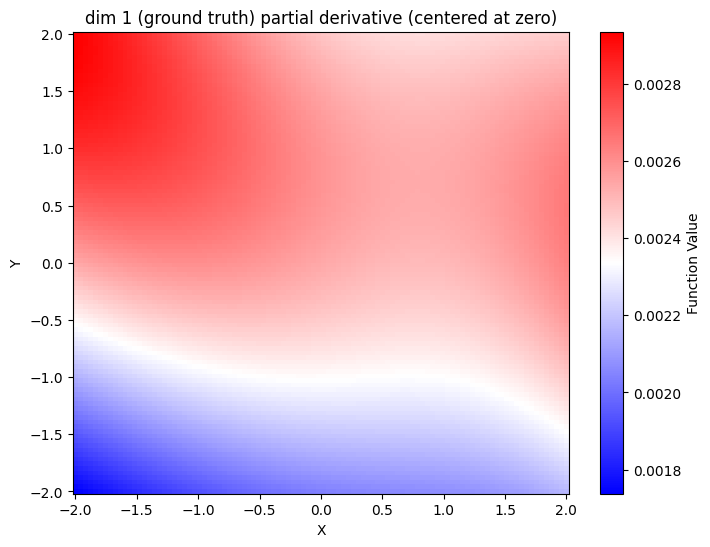

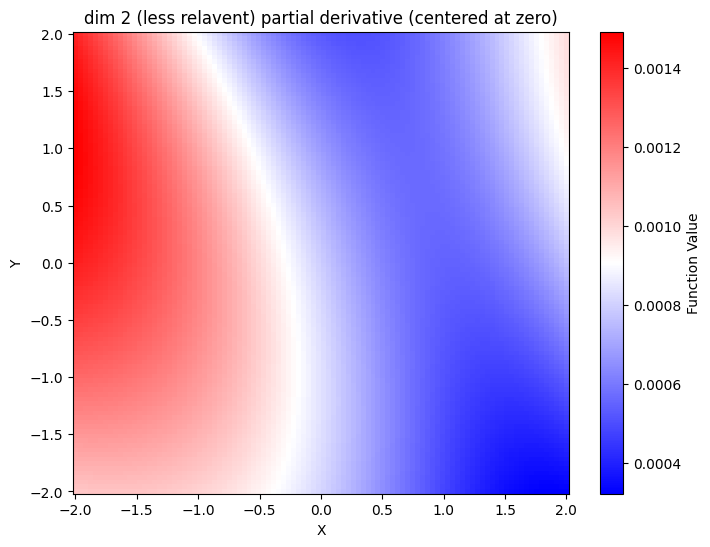

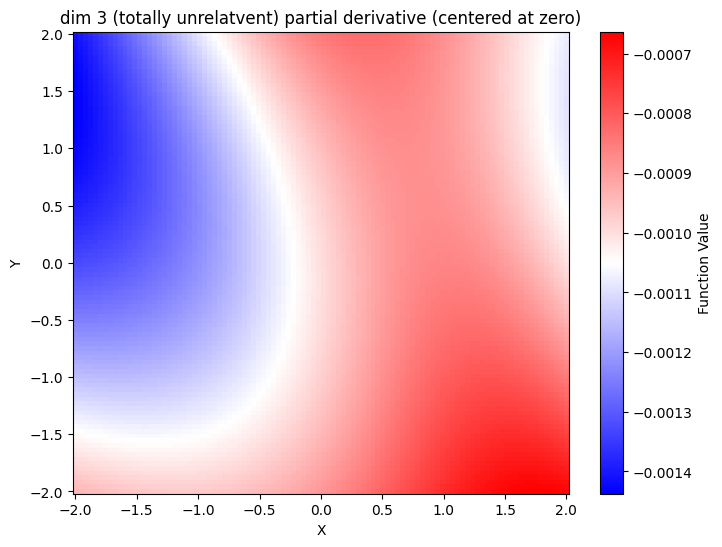

In [186]:
from matplotlib.colors import LinearSegmentedColormap

def my_function(x, y):
    input_tensor=torch.tensor([x,y,0.], requires_grad=True).float()
    output = model(input_tensor)
    gradient_input = torch.autograd.grad(output, input_tensor, torch.ones_like(output), retain_graph=True)[0]
    return gradient_input

x_values = np.linspace(-2, 2, 100)
y_values = np.linspace(-2, 2, 100)

Z = np.zeros((len(x_values), len(y_values)))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        Z[i, j] = my_function(x, y)[0]

# Create custom colormap with 'bwr' and center white at zero
cmap = LinearSegmentedColormap.from_list('bwr_white_centered', ['blue', 'white', 'red'])

X, Y = np.meshgrid(x_values, y_values)
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, cmap=cmap)
plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('dim 1 (ground truth) partial derivative (centered at zero)')
plt.show()





Z = np.zeros((len(x_values), len(y_values)))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        Z[i, j] = my_function(x, y)[1]

# Create custom colormap with 'bwr' and center white at zero
cmap = LinearSegmentedColormap.from_list('bwr_white_centered', ['blue', 'white', 'red'])


X, Y = np.meshgrid(x_values, y_values)
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, cmap=cmap)
plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('dim 2 (less relavent) partial derivative (centered at zero)')
plt.show()




Z = np.zeros((len(x_values), len(y_values)))
for i, x in enumerate(x_values):
    for j, y in enumerate(y_values):
        Z[i, j] = my_function(x, y)[2]

# Create custom colormap with 'bwr' and center white at zero
cmap = LinearSegmentedColormap.from_list('bwr_white_centered', ['blue', 'white', 'red'])

# Plot the heatmap
X, Y = np.meshgrid(x_values, y_values)
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, cmap=cmap)
plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('dim 3 (totally unrelatvent) partial derivative (centered at zero)')
plt.show()


taking the partial derivative of the 3 dim of x, varying the dim 1 and dim 2 of x. 

the partial derivative gives us a better sense of how much changes in x affect the output y. however, the partial derviate depends on the whole input vector, and it is hard to visualize all. here in this samll example, we can vary the 1 and 2 dim of the input vector and see how much the partial dervivative chagnes. 
we can see the partial deriviate of 1 dim has the biggest variance, meaning it affects the output the most. as expected.

## 2: Changes in output accuracy

### Changes in loss

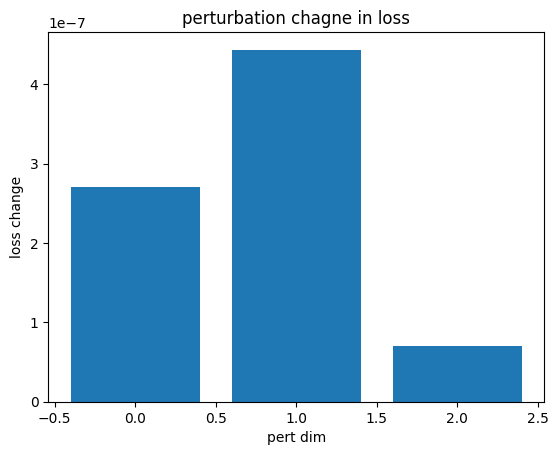

In [208]:
def generate_data(size=555):
    x = torch.rand((size, 3)) 
    # x[:, 0]=x[:, 1]+torch.rand_like(x[:, 1])*0.1
    x[:, 1]=torch.normal(x[:, 0],0.1)
    # x[:, 1]=x[:, 1]+torch.rand_like(x[:, 1])*0.1
    y=(torch.normal(x[:, 0],0.1) + torch.rand_like(x[:, 1])*0.1)
    y=normalize(y)
    return x, y


def pert_loss(pert_dim=0):
    # old loss
    x,y=generate_data(99999)
    orginal_loss = criterion(y, model(x)).item()
    x[:,pert_dim]=torch.rand_like(x[:,pert_dim])
    pert_loss=criterion(y, model(x)).item()
    return (orginal_loss-pert_loss)

plt.bar(np.arange(3), [pert_loss(i) for i in range(3)])
plt.xlabel('pert dim')
plt.ylabel('loss change')
plt.title('perturbation chagne in loss')
plt.show()

the result is not very consistant because the model is sensitive to all 3 dim of input.

## nonlinear correlation

Spearman's Rank Correlation:

Spearman's rank correlation coefficient assesses the strength and direction of association between two variables by ranking their values and computing the correlation between the ranks.
It measures how well the relationship between two variables can be described using a monotonic function, regardless of the specific form of the relationship.
The coefficient ranges from -1 to 1, where:
1 indicates a perfect positive monotonic relationship (as one variable increases, the other also increases).
-1 indicates a perfect negative monotonic relationship (as one variable increases, the other decreases).
0 indicates no monotonic relationship between the variables.
The p-value associated with Spearman's correlation test indicates the probability of obtaining the observed correlation coefficient if the true correlation coefficient were zero (null hypothesis).
Common interpretations of the coefficient magnitude:
0.00 to 0.19: Very weak correlation
0.20 to 0.39: Weak correlation
0.40 to 0.59: Moderate correlation
0.60 to 0.79: Strong correlation
0.80 to 1.00: Very strong correlation
Kendall's Tau:

Kendall's Tau is another non-parametric measure of rank correlation similar to Spearman's correlation.
It measures the similarity of the orderings of the data when ranked by each of the quantities.
The coefficient also ranges from -1 to 1, with similar interpretations as Spearman's correlation.
Kendall's Tau is particularly useful when dealing with data with tied ranks.
The p-value associated with Kendall's Tau test has a similar interpretation to Spearman's correlation.
Mutual Information:

Mutual information measures the amount of information obtained about one variable through observing another variable.
It quantifies the dependence between two variables and is sensitive to both linear and nonlinear relationships.
It ranges from 0 to positive infinity, where higher values indicate stronger dependence between the variables.
However, mutual information does not have a standardized scale for interpretation like Spearman's correlation and Kendall's Tau. Its interpretation depends on the specific context and application.
Generally, higher mutual information values indicate greater association or dependence between the variables.
In summary, higher absolute values of Spearman's correlation coefficient and Kendall's Tau indicate stronger monotonic relationships between variables, while higher mutual information values indicate stronger dependence between variables, whether linear or nonlinear. The interpretation of the correlation coefficients also depends on the context and domain of the data being analyzed.

In [212]:
import numpy as np
from scipy.stats import spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression

# Generate example data
np.random.seed(0)
x = np.linspace(0, 10, 100)
y = np.sin(x) + np.random.normal(0, 0.1, size=x.shape)  # Nonlinear relationship with noise

# Spearman's rank correlation
spearman_corr, spearman_p_value = spearmanr(x, y)
print("\nSpearman's correlation coefficient:", spearman_corr)
print('measure cor or anit cor (1 or -1)')
print("    P-value:", spearman_p_value)
print('>0.3 is consider some weak relationship')

# Kendall's Tau
kendall_tau, kendall_p_value = kendalltau(x, y)
print("\nKendall's Tau:", kendall_tau)
print('similarity of the ordering.')
print("    P-value:", kendall_p_value)
print('>0.3 is consider some weak relationship')

# Mutual Information
mi = mutual_info_regression(x.reshape(-1, 1), y)
print("\nMutual Information:", mi[0])
print('low 0 high inf. the high the tighter corr')


Spearman's correlation coefficient: -0.10187818781878187
measure cor or anit cor (1 or -1)
    P-value: 0.3131662999577446
>0.3 is consider some weak relationship

Kendall's Tau: -0.06141414141414143
similarity of the ordering.
    P-value: 0.3652813176802082
>0.3 is consider some weak relationship

Mutual Information: 1.00782204586233
low 0 high inf. the high the tighter corr


In [214]:
xall,y = generate_data(9999)

for dim in range(3):
    x=xall[:,dim]
    print(f'\n\ndimension: {dim+1}         ')
    # Spearman's rank correlation
    spearman_corr, spearman_p_value = spearmanr(x, y)
    print("\nSpearman's correlation coefficient:", spearman_corr)
    print('measure cor or anit cor (1 or -1)')
    print("    P-value:", spearman_p_value)
    print('>0.3 is consider some weak relationship')

    # Kendall's Tau
    kendall_tau, kendall_p_value = kendalltau(x, y)
    print("\nKendall's Tau:", kendall_tau)
    print('similarity of the ordering.')
    print("    P-value:", kendall_p_value)
    print('>0.3 is consider some weak relationship')

    # Mutual Information
    mi = mutual_info_regression(x.reshape(-1, 1), y)
    print("\nMutual Information:", mi[0])
    print('low 0 high inf. the high the tighter corr')



dimension: 1         

Spearman's correlation coefficient: 0.9454854224423701
measure cor or anit cor (1 or -1)
    P-value: 0.0
>0.3 is consider some weak relationship

Kendall's Tau: 0.7875257734825603
similarity of the ordering.
    P-value: 0.0
>0.3 is consider some weak relationship

Mutual Information: 1.0434389438602727
low 0 high inf. the high the tighter corr


dimension: 2         

Spearman's correlation coefficient: 0.9007848351029413
measure cor or anit cor (1 or -1)
    P-value: 0.0
>0.3 is consider some weak relationship

Kendall's Tau: 0.7124565840997958
similarity of the ordering.
    P-value: 0.0
>0.3 is consider some weak relationship

Mutual Information: 0.7770215573493173
low 0 high inf. the high the tighter corr


dimension: 3         

Spearman's correlation coefficient: -0.011588114658774398
measure cor or anit cor (1 or -1)
    P-value: 0.2465998759899305
>0.3 is consider some weak relationship

Kendall's Tau: -0.007773512209132984
similarity of the ordering.

# Conclusion

the stats way is the best.  
should have read more paper before thinking.